# Keras_CIFAR10_CNN_模型增强

## 导入模块

In [17]:
%matplotlib inline
import os
import PIL
import gzip
import tarfile
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from IPython import display
from functools import partial
from sklearn.preprocessing import normalize

from keras import backend
from keras.utils import np_utils, plot_model
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

from keras.models import load_model
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPool2D, Input, AveragePooling2D
from keras.layers import Activation, Dropout, Flatten, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam

import warnings 
warnings.filterwarnings('ignore')
np.random.seed(42)

## 准备数据

In [18]:
data_dir = r"dataset"
cifar10_file = r"../input/cifar-10-python.tar.gz"

if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

!cp ../input/cifar-10-python.tar.gz dataset/
!tar xzvf dataset/cifar-10-python.tar.gz -C dataset/

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [19]:
cifar10_dir = r"cifar-10-batches-py"
filepath = os.path.join(data_dir, cifar10_dir)
files = os.listdir(filepath)

for fn in files:
    fp = os.path.join(filepath, fn)
    f = open(fp, 'rb')
    if "1" in fn:
        data_b = pickle.load(f, encoding="bytes")
        y_train = np_utils.to_categorical(data_b[b"labels"])
        X_train = np.array(data_b[b"data"])
    f.close()

for fn in files:
    fp = os.path.join(filepath, fn)
    f = open(fp, 'rb')
    if "data" in fn and "1" not in fn:
        data_b = pickle.load(f, encoding="bytes")
        imgs = np.array(data_b[b"data"])
        t_1hot = np_utils.to_categorical(data_b[b"labels"])
        y_train = np.vstack((y_train, t_1hot))
        X_train = np.vstack((X_train, imgs))
    elif "meta" in fn:
        meta = pickle.load(f, encoding="bytes")
        label_dict = [label.decode() for label in meta[b"label_names"]]
    elif "test" in fn:
        test_b = pickle.load(f, encoding="bytes")
        X_test = test_b[b"data"]
        labels = test_b[b"labels"]
        y_test = np_utils.to_categorical(labels)
    f.close()

"""规范化数据以及切分训练集、验证集和测试集"""
X_train = normalize(X_train, axis=0, norm="max")
X_train = X_train.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1).astype("float32")
X_test = normalize(X_test, axis=0, norm="max")
X_test = X_test.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1).astype("float32")
x_train = X_train[10000:]
t_train = y_train[10000:]
x_val   = X_train[:10000]
t_val   = y_train[:10000]

print("all files : \n", files)
print("\nall labels : \n", label_dict)
print("\nimgs   of trainset : ", x_train.shape)
print("labels of trainset : ", t_train.shape)
print("imgs   of   valset : ", x_val.shape)
print("labels of   valset : ", t_val.shape)
print("imgs   of  testset : ", X_test.shape)
print("labels of  testset : ", y_test.shape)

all files : 
 ['data_batch_4', 'data_batch_3', 'data_batch_5', 'data_batch_1', 'readme.html', 'test_batch', 'data_batch_2', 'batches.meta']

all labels : 
 ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

imgs   of trainset :  (40000, 32, 32, 3)
labels of trainset :  (40000, 10)
imgs   of   valset :  (10000, 32, 32, 3)
labels of   valset :  (10000, 10)
imgs   of  testset :  (10000, 32, 32, 3)
labels of  testset :  (10000, 10)


## 定义模型

In [20]:
def myCNN():
    """定义CNN模型"""
    MyConv = partial(Conv2D, kernel_size=(3, 3), padding="same", activation="relu")
    MyMaxPool = partial(MaxPool2D, pool_size=(2, 2))
    
    cifar_input = Input(shape=(32, 32, 3), name="input")
    
    conv1 = MyConv(32, name="conv1")(cifar_input)
    conv2 = MyConv(32, name="conv2")(conv1)
    bn1 = BatchNormalization()(conv2)
    pool1 = MyMaxPool(name="pool1")(bn1)
    dropout1 = Dropout(0.5)(pool1)
    
    conv3 = MyConv(64, name="conv3")(dropout1)
    conv4 = MyConv(64, name="conv4")(conv3)
    bn2 = BatchNormalization()(conv4)
    pool2 = MyMaxPool(name="pool2")(bn2)
    dropout2 = Dropout(0.5)(pool2)
    
    flat1 = Flatten()(dropout2)    
    dense1 = Dense(512, activation="relu", name="dense1")(flat1)
    dropout3 = Dropout(0.5)(dense1)
    y_output = Dense(10, activation="softmax", name="output")(dropout3)
    
    model = Model(inputs=cifar_input, outputs=y_output)
    return model
model = myCNN()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 16, 16, 64)        18496     
__________

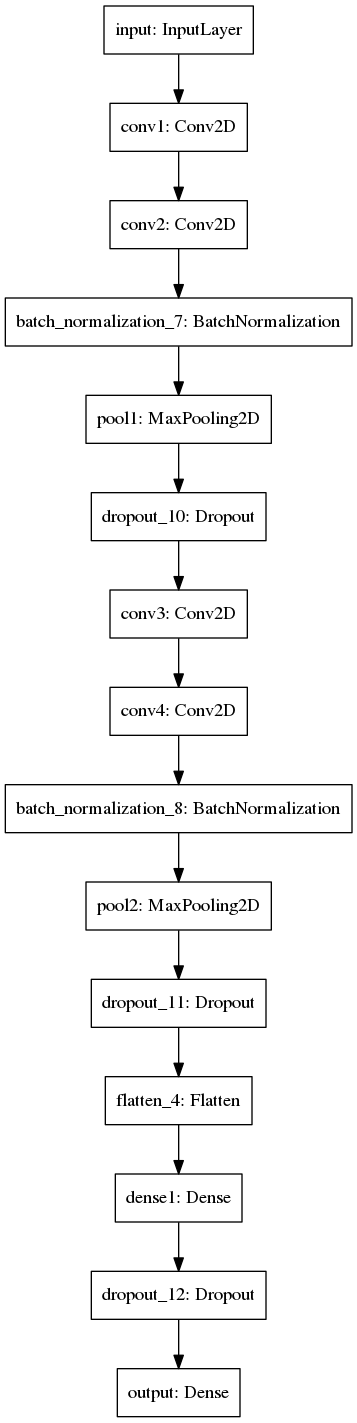

In [21]:
if not os.path.isdir(r"model_img"):
    os.mkdir(r"model_img")
plot_model(model, r"model_img/CNN_Dropout_BN.png")
img = PIL.Image.open(r"model_img/CNN_Dropout_BN.png")
display.display(img)

## 训练模型

In [22]:
"""训练模型并保存模型及训练历史
保存模型单独创建一个子文件夹modeldir, 保存训练历史则为单个文件hisfile"""

models_name = "Keras_CIFAR10_CNN_Dropout_BN" # 模型名称的公共前缀
factor_list = [""] # 此次调参的变量列表

model_list = []      # 模型名称列表
for i in range(len(factor_list)):
    modelname = models_name + factor_list[i] + ".h5"
    model_list.append(modelname)

# 创建模型保存子目录modeldir
if not os.path.isdir("saved_model"): 
    os.mkdir("saved_model")
modeldir = r"saved_model"

# 创建训练历史保存目录
if not os.path.isdir("train_history"): 
    os.mkdir("train_history")
# 设置训练历史文件路径
hisfile = r"train_history/Keras_CIFAR10_CNN_Dropout_BN.train_history" 
# 每个模型及其对应的训练历史作为键值对{modelname: train_history}
# train_history为字典，含四个key，代表train和val的loss和acc
model_train_history = dict() 

epochs=200
steps_per_epoch=1250
for i in range(len(model_list)):
    model = myCNN()
    modelname = model_list[i]
    modelpath = os.path.join(modeldir, modelname)    
    
    train_his = np.array([]).reshape(-1, 2)
    val_his = np.array([]).reshape(-1, 2)
    
    datagen = ImageDataGenerator(  rotation_range=20, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   height_shift_range=0.2, 
                                   width_shift_range=0.2, 
                                   horizontal_flip=True)
    datagen.fit(x_train)
    
    lr = 0.001
    model.compile(loss="categorical_crossentropy", 
                  optimizer=keras.optimizers.Adam(lr=lr),
                  metrics=["accuracy"])
    print("\ntraining model : ", modelname)
    
    ck_epoch, max_val_acc = 0, 0.0
    for epoch in range(epochs+1):
        i = 0
        tr_his = []
        for X, y in datagen.flow(x_train, t_train, batch_size=32):
            his = model.train_on_batch(X, y)
            tr_his.append(his)
            i += 1
            if i >= steps_per_epoch: break
        tr = np.mean(tr_his, axis=0)
        val = model.evaluate(x_val, t_val, verbose=0)
        train_his = np.vstack((train_his, tr))
        val_his = np.vstack((val_his, val))
        if epoch<10 or epoch%5==0:
            print("%4d epoch: train acc: %8f loss: %8f      val acc: %8f loss: %8f"%(epoch, tr[1], tr[0], val[1], val[0]))
        # 设置保存模型
        if val[1] > max_val_acc: 
            model.save(modelpath)
            print("val acc improved from %6f to %6f"%(max_val_acc, val[1]))
            max_val_acc = val[1]
            ck_epoch = epoch
        # 调学习率: 
        if epoch>=80 and epoch%40 == 0 and lr >= 1e-5:
            if epoch%80 == 0:
                lr *= 0.2
            else:
                lr *= 0.5
            model.compile(loss="categorical_crossentropy", 
                          optimizer=keras.optimizers.Adam(lr=lr),
                          metrics=["accuracy"])
            print("lr : ", lr)
        # 提前停止
        if epoch-ck_epoch>40: 
            print("Early stop !")
            break  
    model_train_history[modelname] = {"acc": train_his[:, 1], "val_acc": val_his[:, 1],
                                      "loss": train_his[:, 0], "val_loss": val_his[:, 0]}

"""保存训练历史"""
fo = open(hisfile, 'wb')
pickle.dump(model_train_history, fo)
fo.close() 


training model :  Keras_CIFAR10_CNN_Dropout_BN.h5
   0 epoch: train acc: 0.262075 loss: 2.072377      val acc: 0.346000 loss: 1.943147
val acc improved from 0.000000 to 0.346000
   1 epoch: train acc: 0.341650 loss: 1.793304      val acc: 0.399400 loss: 2.124329
val acc improved from 0.346000 to 0.399400
   2 epoch: train acc: 0.385300 loss: 1.678177      val acc: 0.429000 loss: 1.705969
val acc improved from 0.399400 to 0.429000
   3 epoch: train acc: 0.417125 loss: 1.604262      val acc: 0.488400 loss: 1.472190
val acc improved from 0.429000 to 0.488400
   4 epoch: train acc: 0.447000 loss: 1.534705      val acc: 0.461500 loss: 1.716611
   5 epoch: train acc: 0.469100 loss: 1.475227      val acc: 0.483100 loss: 1.536362
   6 epoch: train acc: 0.486375 loss: 1.428487      val acc: 0.515100 loss: 1.573880
val acc improved from 0.488400 to 0.515100
   7 epoch: train acc: 0.510375 loss: 1.365057      val acc: 0.596500 loss: 1.201344
val acc improved from 0.515100 to 0.596500
   8 epoch:

## 可视化训练过程

In [32]:
def show_train_history(saved_history, his_img_file):  
    modelnames = sorted(list(saved_history.keys()))
    train = ["acc", "loss"]
    val = ["val_acc", "val_loss"]
    
    """作loss和acc两个图"""
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    ax = ax.flatten()
    color_add = 0.9/len(saved_history)
    for i in range(2):
        c = 0.05
        for j in range(len(saved_history)):
            modelname = modelnames[j]
            train_history = saved_history[modelname]
            ax[i].plot(train_history[train[i]], 
                       color=(0, 1-c, 0),
                       linestyle="-",
                       label="train_"+modelname[21:-3])
            ax[i].plot(train_history[val[i]], 
                       color=(c, 0, 1-c),
                       linestyle="-",
                       label=modelname[21:-3])
            c += color_add
        ax[i].set_title('Train History')
        ax[i].set_ylabel(train[i])  
        ax[i].set_xlabel('Epoch')  
    ax[0].legend(loc="lower right")
    ax[1].legend(loc="upper right") 
    ax[0].set_ylim(0.0, 1.0)
    ax[1].set_ylim(0.0, 2)
    plt.suptitle("CNN_Dropout_BN")
    
    print("saved img: ", his_img_file)
    plt.savefig(his_img_file)
    plt.show()

saved img:  his_img/CNN_Dropout_BN.png


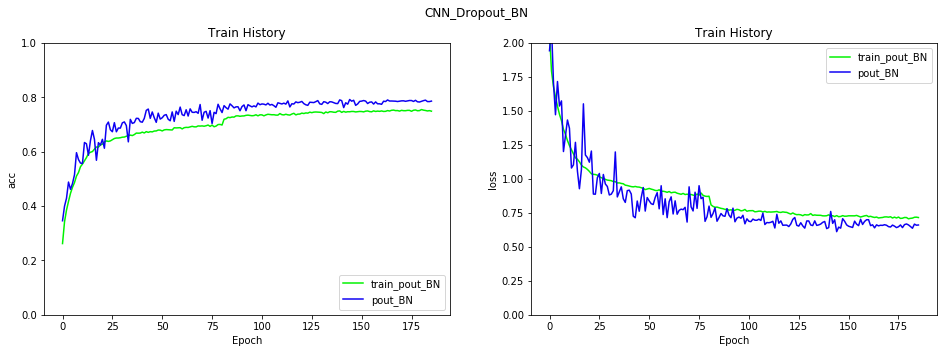

In [33]:
"""载入训练历史并可视化, 并且保存图片"""
if not os.path.isdir("his_img"):
    os.mkdir("his_img")
his_img_file = r"his_img/CNN_Dropout_BN.png"

fo2 = open(hisfile, "rb")

saved_history1 = pickle.load(fo2)
show_train_history(saved_history1, his_img_file)

## 用测试集测试模型

In [25]:
smodel = load_model(modelpath)

print("\ntest model : ", os.path.basename(modelpath))
loss, acc = smodel.evaluate(X_test, y_test)    
print("acc: %.4f \t loss: %.4f"%(acc, loss))


test model :  Keras_CIFAR10_CNN_Dropout_BN.h5
10000/10000 [==============================] - 1s 141us/step
acc: 0.7885 	 loss: 0.6374
